In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


![](https://i.imgur.com/bOFkueI.pnghttps://)

In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras_cv.losses import FocalLoss
import pandas as pd
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

%matplotlib inline

# Hyperparameters

In [3]:
# Try these modifications

LEARNING_RATE = 0.001    # Lower learning rate
BATCH_SIZE = 4  # Increase batch size if memory allows
WEIGHT_DECAY = 1e-5  # Adjust weight decay
GLOBAL_CLIPNORM = 1.0
SPLIT_RATIO=0.2

In [4]:
class_ids = ['car', 'trafficLight-YellowLeft', 'pedestrian', 'trafficLight-GreenLeft', 'trafficLight-Green', 'biker', 'trafficLight-Yellow', 'truck', 
             'trafficLight-RedLeft', 'trafficLight-Red', 'trafficLight']
class_mapping = dict(zip(range(len(class_ids)), class_ids))



# Path to images and annotations

In [5]:
path_image="/kaggle/input/self-driving-car/export/"
annot_path="/kaggle/input/self-driving-car/export/"


# Get all XML file paths in path_annot and sort them

xml_files = sorted(
    [
        os.path.join(annot_path, file_name)
        for file_name in os.listdir(annot_path)
        if file_name.endswith(".xml")
    ]
)


# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_image, file_name)
        for file_name in os.listdir(path_image)
        if file_name.endswith(".jpg")
    ]
)

In [6]:

class_names = set()

# Function to parse XML annotations and extract class names
def extract_class_names(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Loop through each object in the XML and extract the class name
    for obj in root.iter("object"):
        class_name = obj.find("name").text
        class_names.add(class_name)

# Loop through XML files and extract class names with tqdm for progress
for xml_file in tqdm(xml_files, desc="Extracting class names", unit="file"):
    extract_class_names(xml_file)

# Print unique class names
print("Unique class names:")
print(class_names)

Extracting class names:   0%|          | 0/30000 [00:00<?, ?file/s]

Unique class names:
{'truck', 'pedestrian', 'trafficLight-YellowLeft', 'trafficLight', 'trafficLight-GreenLeft', 'biker', 'trafficLight-Green', 'trafficLight-Yellow', 'car', 'trafficLight-Red', 'trafficLight-RedLeft'}


In [7]:

rows, cols = 5, 5
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
axes = ax.flatten()

# Make sure the class_names list has enough elements for the available images
num_images = min(len(jpg_files), rows * cols)
class_names_list = list(class_names)[:num_images]

for i, ax in enumerate(axes[:num_images]):
    img = mpimg.imread(jpg_files[i])
    ax.imshow(img)
    ax.set_title(f"Class: {class_names_list[i % len(class_names_list)]}")  # Cycle through class names if less than images
    ax.axis('off')

# Hide any remaining axes
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Counting class occurrences:   0%|          | 0/30000 [00:00<?, ?file/s]

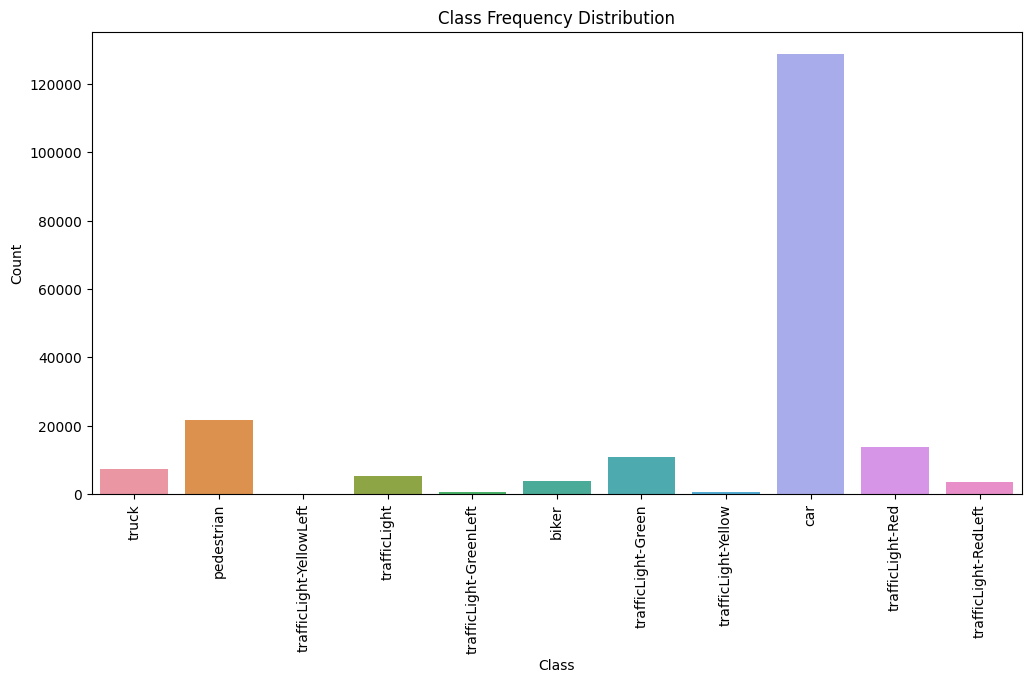

In [8]:


class_count = {class_name: 0 for class_name in class_names}

def count_classes_in_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for obj in root.iter("object"):
        class_name = obj.find("name").text
        if class_name in class_count:
            class_count[class_name] += 1

for xml_file in tqdm(xml_files, desc="Counting class occurrences", unit="file"):
    count_classes_in_xml(xml_file)

class_count_df = pd.DataFrame(list(class_count.items()), columns=["Class", "Count"])

plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Count", data=class_count_df)
plt.xticks(rotation=90)
plt.title("Class Frequency Distribution")
plt.show()


* The function below reads the XML file and finds the image name and path, and then iterates over each object in the XML file to extract the bounding box coordinates and class labels for each object.

* The function returns three values: the image path, a list of bounding boxes (each represented as a list of four floats: xmin, ymin, xmax, ymax), and a list of class IDs (represented as integers) corresponding to each bounding box. The class IDs are obtained by mapping the class labels to integer values using a dictionary called class_mapping.

In [9]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_image, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [10]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# split  data from train & valid

In [11]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

* The dictionary has two keys, 'boxes' and 'classes', each of which maps to a TensorFlow RaggedTensor or Tensor object. The 'boxes' Tensor has a shape of [batch, num_boxes, 4], where batch is the number of images in the batch and num_boxes is the maximum number of bounding boxes in any image. The 4 represents the four values needed to define a bounding box: xmin, ymin, xmax, ymax.

* The 'classes' Tensor has a shape of [batch, num_boxes], where each element represents the class label for the corresponding bounding box in the 'boxes' Tensor. The num_boxes dimension may be ragged, which means that the number of boxes may vary across images in the batch.

## Final dict should be:

In [12]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [13]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640,640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset

In [14]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# create valid dataset

In [15]:
resizing = keras_cv.layers.JitteredResize(
                target_size=(640,640),
                scale_factor=(0.75, 1.3),
                bounding_box_format="xyxy")

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualization

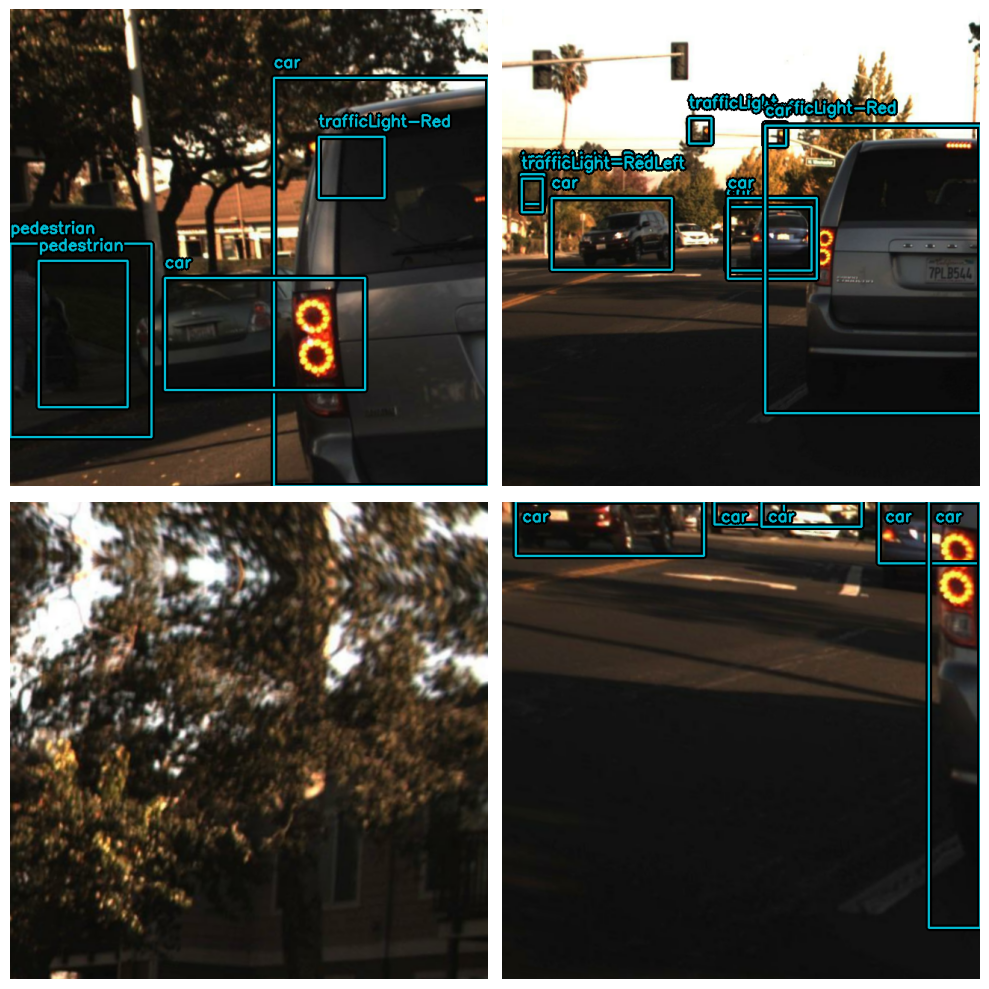

In [16]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# visualize from valid dataset

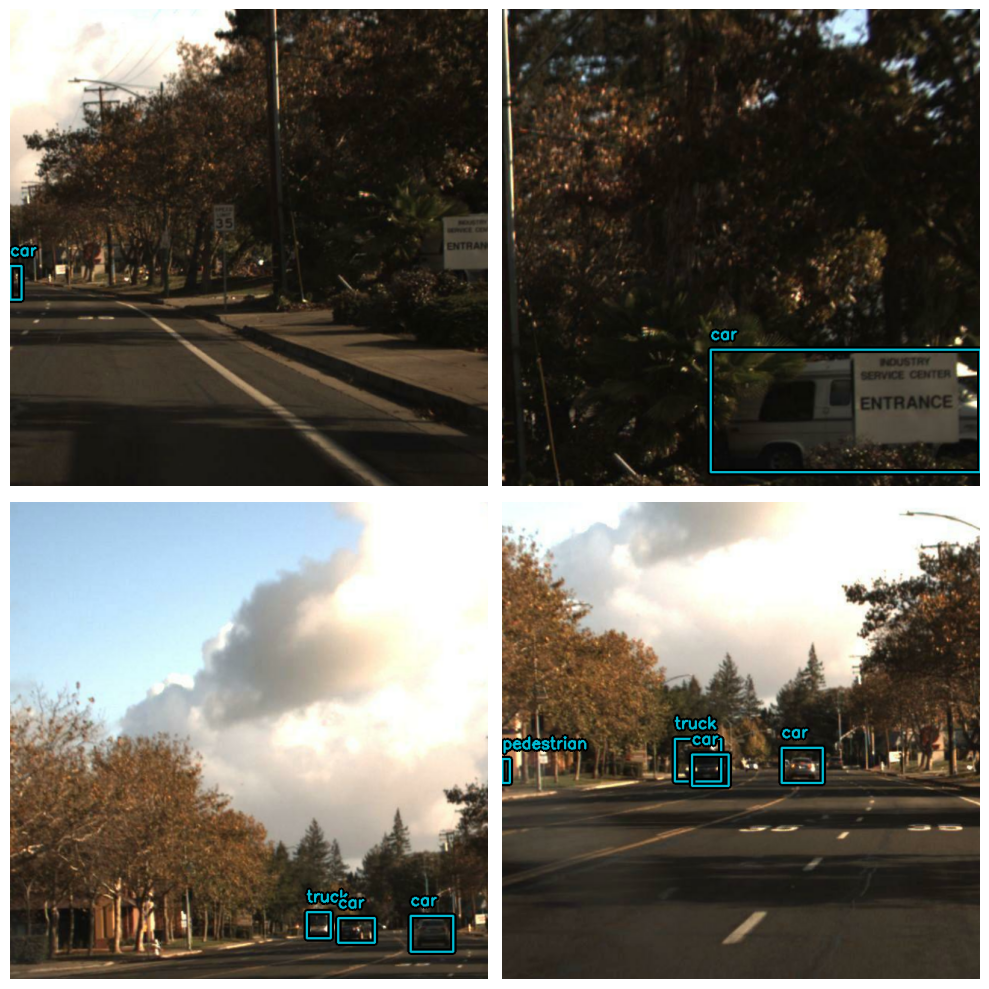

In [17]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

* We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.

In [18]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.take(100)
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.take(100)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Creating Model


* Next, let's build a YOLOV8 model using the YOLOV8Detector, which accepts a feature extractor as the backbone argument, a num_classes argument that specifies the number of object classes to detect based on the size of the class_mapping list, a bounding_box_format argument that informs the model of the format of the bbox in the dataset, and a finally, the feature pyramid network (FPN) depth is specified by the fpn_depth argument.

* It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to KerasCV

In [19]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_l_backbone_coco")

model = keras_cv.models.YOLOV8Detector( num_classes=len(class_mapping),bounding_box_format="xyxy",backbone=backbone,fpn_depth=2,  
        prediction_decoder=keras_cv.layers.NonMaxSuppression(bounding_box_format="xyxy",from_logits=False,
        iou_threshold=0.5,
        confidence_threshold=0.1,
        max_detections=50))



optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY,global_clipnorm=GLOBAL_CLIPNORM)

# Reasonable starting point
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=LEARNING_RATE,decay_steps=10000,alpha=0.01)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule,weight_decay=WEIGHT_DECAY,global_clipnorm=GLOBAL_CLIPNORM)
model.compile(optimizer=optimizer, classification_loss=FocalLoss(alpha=0.25, gamma=2.0), box_loss="ciou")

model.summary()


Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, None, None,    │     19,831,744 │ input_layer_1[0][0]    │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 512), (None,     │                │                        │
│                           │ None, None, 512)]      │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat (Repeat)           │ (None, None, None,     │              0 │ functional[0][2]       │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_1 (Repeat)         │ (None, None, None,     │              0 │ repeat[0][0]           │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ repeat_1[0][0],        │
│ (Concatenate)             │ 1024)                  │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │        524,288 │ concatenate_5[0][0]    │
│ (Conv2D)                  │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          2,048 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 256)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │        589,824 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │          1,024 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 256)                   │                │                        │
├──────────────────────

 Total params: 39,417,761 (150.37 MB)

 Trainable params: 39,374,881 (150.20 MB)

 Non-trainable params: 42,880 (167.50 KB)

In [20]:
# keras.utils.plot_model(model,show_shapes=True)

# COCO Metric Callback

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [22]:
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=3,
            callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5"), tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - box_loss: 2.7060 - class_loss: 0.2422 - loss: 2.9482 - val_box_loss: 0.0492 - val_class_loss: 0.0461 - val_loss: 0.0953 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - box_loss: 2.6770 - class_loss: 0.0063 - loss: 2.6834 - val_box_loss: 1.0912 - val_class_loss: 0.0011 - val_loss: 1.0924 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max

# Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


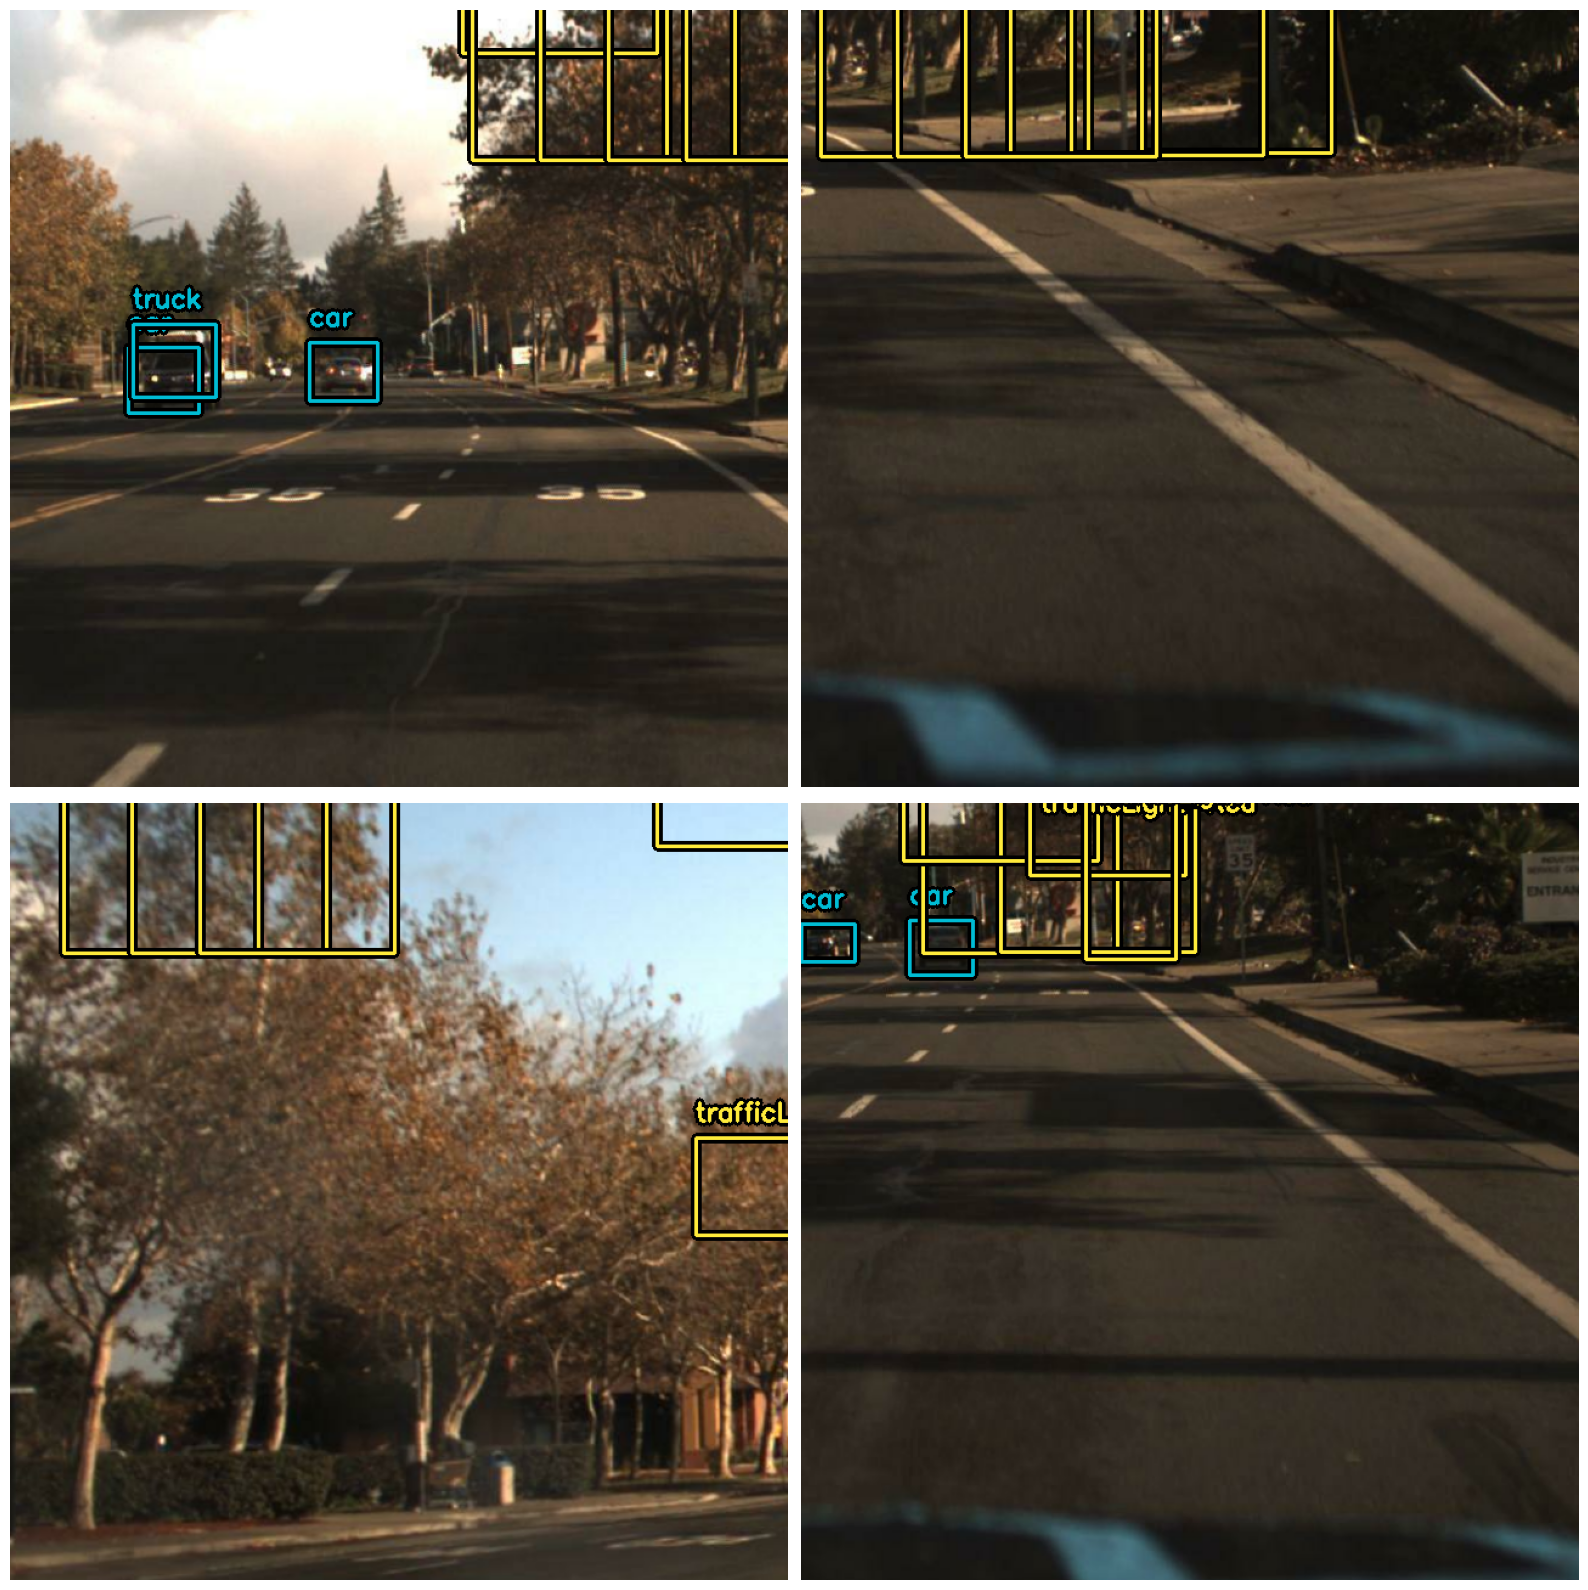

In [23]:
import tensorflow as tf
from keras_cv import visualization, bounding_box

def visualize_detections(model, dataset, bounding_box_format, class_mapping, conf_threshold=0.5, max_detections=5):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    
    # Extract boxes from y_pred
    if isinstance(y_pred, dict):
        y_pred_boxes = y_pred["boxes"]  # Shape: (batch_size, 100, 4)
        y_pred_classes = y_pred["classes"]  # Shape: (batch_size, 100)
        y_pred_confidence = y_pred["confidence"]  # Shape: (batch_size, 100)
    else:
        raise ValueError("y_pred must be a dictionary with 'boxes', 'classes', and 'confidence'")

    # Filter and trim predictions
    y_pred_boxes_trimmed = []
    y_pred_classes_trimmed = []
    for i in range(len(images)):
        conf = y_pred_confidence[i]
        boxes = y_pred_boxes[i]
        classes = y_pred_classes[i]
        
        # Filter by confidence threshold
        mask = conf > conf_threshold
        filtered_conf = conf[mask]
        filtered_boxes = boxes[mask]
        filtered_classes = classes[mask]
        
        # Sort by confidence and take top max_detections
        if tf.shape(filtered_conf)[0] > 0:
            top_indices = tf.argsort(filtered_conf, direction="DESCENDING")[:max_detections]
            filtered_boxes = tf.gather(filtered_boxes, top_indices)
            filtered_classes = tf.gather(filtered_classes, top_indices)
        else:
            filtered_boxes = tf.zeros((0, 4), dtype=tf.float32)
            filtered_classes = tf.zeros((0,), dtype=tf.int32)
        
        # Pad to max_detections
        num_detections = tf.shape(filtered_boxes)[0]
        padding = [[0, max_detections - num_detections], [0, 0]]
        padded_boxes = tf.pad(filtered_boxes, padding, constant_values=-1)  # Pad with -1 for invalid boxes
        padded_classes = tf.pad(filtered_classes, [[0, max_detections - num_detections]], constant_values=-1)
        
        y_pred_boxes_trimmed.append(padded_boxes)
        y_pred_classes_trimmed.append(padded_classes)
    
    # Stack into fixed-size tensors
    y_pred_boxes_padded = tf.stack(y_pred_boxes_trimmed, axis=0)  # Shape: (batch_size, max_detections, 4)
    y_pred_classes_padded = tf.stack(y_pred_classes_trimmed, axis=0)  # Shape: (batch_size, max_detections)

    # Combine into a dictionary
    y_pred_formatted = {
        "boxes": y_pred_boxes_padded,
        "classes": y_pred_classes_padded
    }

    # Visualize
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred_formatted,
        scale=8,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

# Run the function
visualize_detections(
    model,
    dataset=val_ds,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,  # Assuming defined elsewhere
    conf_threshold=0.5,
    max_detections=5
)